# Twitter Fingers

**Build an NLP model to analyze Twitter sentiments about Apple and Google products**

> Flatiron School Project #4
* Student Name: Hiten Patel 
* Student Pace: Full Time Online 
* Scheduled Project Review: 11/12/20 @ 3pm 
* Instructor Name: James Irving 
* Blog Post URL: https://hpatel530.github.io/blog_number_5_by_hiten_patel


# Introduction

In one day, there are over 500 million tweets among all twitter users. That's 6,000 tweets every second. You can assume they are either positive, negative or neither. They could be about a person, place, or thing. In this case, it will be about products. Apple has over 13 million twitter followers and Google has over 22 million twitter followers. The goal of this project is to build a Natural Processing Language model to analyze twitter sentiments about Apple and Google products as either positive, negative or neutral. The dataset comes from CrowdFlower via data.world and it contains over 9,000 tweets that include all words that are related to the Apple or Google brand. 

Questions we will be looking to answer are; 
* What is the best way to preprocess the data? Word_tokenizer or Tweet_tokenizer? Both methods are useful, effective and each have there advantages. 
* What type of vectorizer should we use? Count vectorizer or tfidf vectorizer?
* What is the best model to use? Support Vector Machines, Random Forest Classifier or MultinomialNB?
* How can the companies use consumer feelings/opinions about a product or service to their business advantage?





# Obtain 

## Import Libraries and Packages

In [304]:
#!pip install -U fsds
from fsds.imports import *

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# ignore warning signs 
import warnings
warnings.filterwarnings('ignore')

# setting a random seed for reproducibility
np.random.seed(0)

# importing nltk packages
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist

# importing sklearn packages 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# importing wordcloud packages
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator

# install and import LIME packages
#!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

## Functions 

In [306]:
def evaluate_classification(model, X_train_tf, X_test_tf, y_train, y_test, classes = None, 
                            normalize = 'true', cmap='summer', label = ''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - Confusion Matrix for training and test 
        - ROC Curve for training and test 
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train_tf: train_test_split & preprocessed
        X_test_tf: train_test_split & preprocessed
        y_train: train_test_split
        y_test: train_test_split 
        label: optional label for type of test 
        
        Modified Function, Citation:
        https://github.com/jirvingphd/fsds_070620_FT_cohort_notes/blob/master/Mod_3/
        mod_3_classification_project/bonus%20notebooks/classification_project_OH1_pipelines_SHAP%20.ipynb
        
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train_tf)
    y_pred_test = model.predict(X_test_tf)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names = classes)) 
    
    # confusion matrix 
    plot_confusion_matrix(model, X_train_tf, y_train, labels=classes, normalize = normalize,
                          cmap = cmap)
    plt.xticks(rotation='vertical')
    plt.title('Confusion Matrix Training')
    plt.show()
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names = classes))
    
    # confusion matrix 
    plot_confusion_matrix(model, X_test_tf, y_test,  labels=classes, normalize = normalize, 
                          cmap = cmap)
    plt.xticks(rotation='vertical')
    plt.title('Confusion Matrix Testing')
    plt.show()

## Import Dataset 

In [307]:
# website for data source: https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv
df = pd.read_csv('https://query.data.world/s/vynyfbrd6bfo3d4qjrazjvxshijelf', encoding= 'unicode_escape')

# Scrub

**Initial inspection of data, reviewing features, target (if any), data types, shape(size) of data, and checking for nulls**

In [308]:
# observe shape and preview dataset 
print(df.shape)
df.head()

(9093, 3)


tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [309]:
# overview of the data with .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Rename Columns

In [310]:
# rename columns for a cleaner look and preview 
df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "tweet_talks_about",
                   "is_there_an_emotion_directed_at_a_brand_or_product": 'type_of_emotion'}, inplace=True)
df.head()

tweet   tweet_talks_about  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

    type_of_emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

## type_of_emotion.value_counts

In [311]:
# reviewing values for target data
df.type_of_emotion.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: type_of_emotion, dtype: int64

## Drop Unnecessary Rows

In [312]:
# creating a variable to extract 'I can't tell' type_of_emotion
cant_tell = df[df.type_of_emotion == "I can't tell"]
cant_tell

tweet tweet_talks_about  \
90    Thanks to @mention for publishing the news of ...               NaN   
102   ÛÏ@mention &quot;Apple has opened a pop-up st...               NaN   
237   Just what America needs. RT @mention Google to...               NaN   
341   The queue at the Apple Store in Austin is FOUR...               NaN   
368   Hope it's better than wave RT @mention Buzz is...               NaN   
...                                                 ...               ...   
9020  It's funny watching a room full of people hold...               NaN   
9032  @mention yeah, we have @mention , Google has n...               NaN   
9037  @mention Yes, the Google presentation was not ...               NaN   
9058  &quot;Do you know what Apple is really good at...               NaN   
9066  How much you want to bet Apple is disproportio...             Apple   

     type_of_emotion  
90      I can't tell  
102     I can't tell  
237     I can't tell  
341     I can't tell  
368     I can't tell  
...              ...  
9020    I can't tell  
9032    I can't tell  
9037    I can't tell  
9058    I can't tell  
9066    I can't tell  

[156 rows x 3 columns]

In [313]:
# drop cant_tell rows, only want positive/negative/no emotion 
df.drop(cant_tell.index, inplace = True)

In [314]:
# observing shape of dataset
df.shape

(8937, 3)

## Remap Categories

In [315]:
# remap categories 
emotion_map = {'No emotion toward brand or product': 'No emotion', 
              'Positive emotion': 'Positive emotion',
              'Negative emotion': 'Negative emotion'}

df.type_of_emotion = df.type_of_emotion.map(emotion_map)
df.type_of_emotion.value_counts()

No emotion          5389
Positive emotion    2978
Negative emotion     570
Name: type_of_emotion, dtype: int64

## Check Nulls 

In [316]:
# calculating percentage of data is nulls 
nulls = df.isna().sum()
null_percent = nulls[nulls>0] / len(df)
null_percent.to_frame('% Null').style.background_gradient(cmap='Reds')

In [317]:
# observing value_counts for column tweet_talks_about 
df.tweet_talks_about.value_counts(dropna=False)

NaN                                5655
iPad                                942
Apple                               659
iPad or iPhone App                  470
Google                              429
iPhone                              296
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: tweet_talks_about, dtype: int64

## Drop Nulls 

In [318]:
# column is unnecssary in dataset, over 63% null
df = df.drop(columns='tweet_talks_about')

In [319]:
# reviewing dataset, data does not match due to one null value  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            8936 non-null   object
 1   type_of_emotion  8937 non-null   object
dtypes: object(2)
memory usage: 209.5+ KB


In [320]:
# dropping row with null value  
df.dropna(inplace=True)

In [321]:
# reviewing dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            8936 non-null   object
 1   type_of_emotion  8936 non-null   object
dtypes: object(2)
memory usage: 209.4+ KB


# Explore

## Creating Corpus Variable 

In [322]:
# creating corpus variable which contains all tweets from df.tweet column
corpus = df['tweet'].to_list()
corpus[:10]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaV

In [323]:
# converting multiple tweets to one corpus: bag-of-words
corpus = ",".join(corpus)

## Instantiate Stopwords

In [324]:
# instantiate stopwords, add punctuations and special punctuations 
stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(["''", '""', '...', '``'])

## Create Tokens: 2 Methods

### Word_tokenize()

**processes and separates hashtags and urls better compared to tweet_tokenizer**

In [325]:
# creating tokens with word_tokenize 
tokens = word_tokenize(corpus)

In [326]:
# preview tokens
tokens[:25]

['.',
 '@',
 'wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 '.',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#',
 'RISE_Austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'I',
 'need',
 'to',
 'upgrade']

#### Removing Stopwords

In [327]:
# removing stopwords from tokens 
stopped_tokens = [token.lower() for token in tokens if token.lower() not in stopwords_list]
stopped_tokens[:25]

['wesley83',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw.',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad/iphone',
 'app',
 "'ll",
 'likely',
 'appreciate',
 'design',
 'also',
 "'re"]

### TweetTokenizer()

**processes and separates @mentions and apostrophes better compared to word_tokenize**

In [328]:
# instantiate TweetTokenizer 
tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, preserve_case=False)

In [329]:
# create tokens_2 with TweetTokenizier 
tokens_2 = tokenizer.tokenize(corpus)

In [330]:
# preview tokens_2
tokens_2[:25]

['.',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i',
 'need',
 'to',
 'upgrade',
 '.',
 'plugin',
 'stations']

#### Removing Stopwords

In [331]:
# removing stopwords from tokens 
stopped_tokens_2 = [token.lower() for token in tokens_2 if token.lower() not in stopwords_list]
stopped_tokens_2[:25]

['3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 '#rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 '#sxsw',
 'know',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 'ts']

### Generate FreqDist 

In [332]:
# generate frequency distribution for each stopped_tokens
freq = FreqDist(stopped_tokens)
freq_common = freq.most_common(25)

# # generate frequency distribution for each stopped_tokens
freq_2 = FreqDist(stopped_tokens_2)
freq_common_2 = freq_2.most_common(25)

# # create datafram
df_1 = pd.DataFrame(freq_common, columns = ["Word","Frequency"])
df_1 = df_1.style.set_caption('Word_Tokenize Most Common')
df_2 = pd.DataFrame(freq_common_2, columns = ["Word","Frequency"])
df_2 = df_2.style.set_caption('Tweet_Tokenizer Most Common')
display(df_1, df_2)

>**Observation: Most frequent words from both list are sxsw, mention, link, rt. We will add these words to the stop word list.** 

In [333]:
stopwords_list.extend(['sxsw', 'mention', 'link', 'rt', '#sxsw'])

## Word Cloud

In [334]:
# importing and creating a twitter mask 
twitter_mask = np.array(Image.open("twitter_mask.png"))
twitter_mask

array([[[  2,   2,   2, 110],
        [180, 180, 180, 238],
        [253, 253, 253, 255],
        ...,
        [250, 250, 250, 255],
        [158, 158, 158, 233],
        [  2,   2,   2, 110]],

       [[180, 180, 180, 238],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[253, 253, 253, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       ...,

       [[250, 250, 250, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       [[158, 158, 158, 233],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[  2

### Visual: Word_tokenize

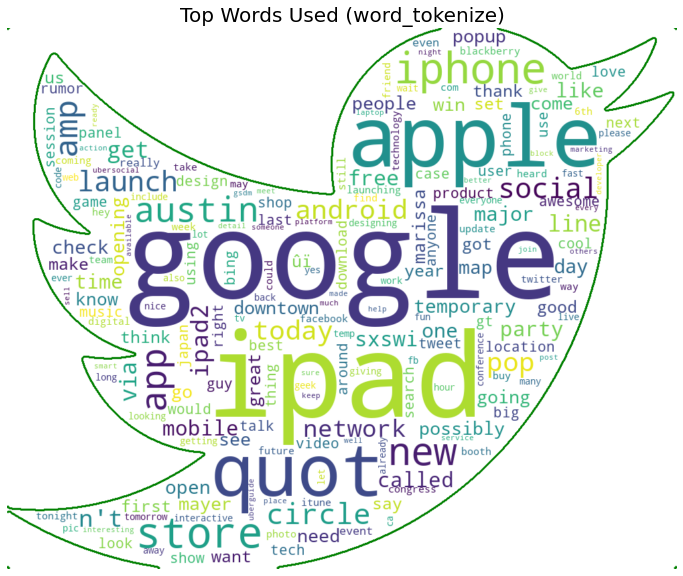

In [335]:
# creating a word cloud image with a twitter mask 
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False, mask=twitter_mask, 
                      background_color='white', width=1800,
                      height=1400, contour_color='green', contour_width=2)
wordcloud.generate(",".join(stopped_tokens))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words Used (word_tokenize)', size=20)
plt.axis("off")
plt.show()

### Visual: Tweet_tokenizer

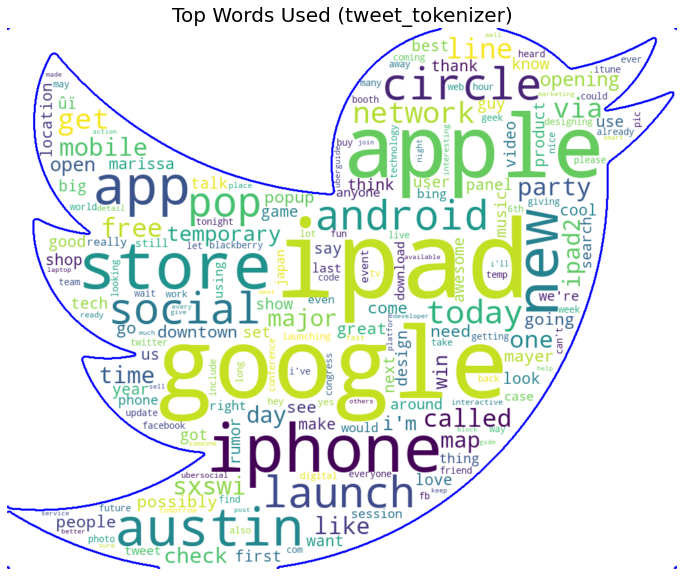

In [336]:
# creating a word cloud image 
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False, mask=twitter_mask, 
                      background_color='white', width=1800,
                      height=1400, contour_color='blue', contour_width=2)
wordcloud.generate(','.join(stopped_tokens_2))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words Used (tweet_tokenizer)', size=20)
plt.axis("off")
plt.show()

### Visual: Neutral Tweets

In [337]:
# creating a corpus for neutral tweets only 
neutral = df[df.type_of_emotion == "No emotion"]
neutral_corpus = neutral.tweet.to_list()
neutral_corpus = ",".join(neutral_corpus)

In [338]:
# word tokenize and lowercase all words 
neutral_tokens = word_tokenize(neutral_corpus)
neutral_stopped = [token.lower() for token in neutral_tokens if token.lower() not in stopwords_list]

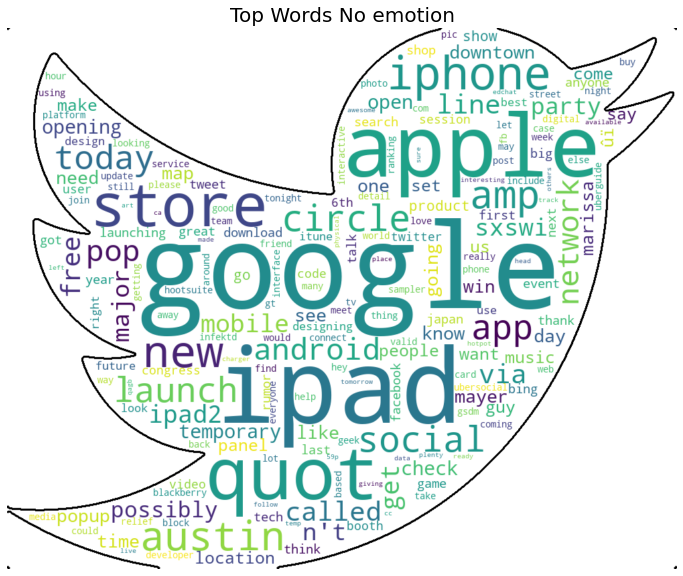

In [339]:
# generating a wordcloud with a twitter mask for neutral words only 
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False, mask=twitter_mask, 
                      background_color='white', width=1800,
                      height=1400, contour_color='black', contour_width=2)
wordcloud.generate(','.join(neutral_stopped))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words No emotion', size=20)
plt.axis("off")
plt.show()

### Visual: Positive Tweets

In [340]:
# creating a corpus for positive tweets only 
positive = df[df.type_of_emotion == "Positive emotion"]
positive_corpus = positive.tweet.to_list()
positive_corpus = ",".join(positive_corpus)

In [341]:
# word tokenize and lowercase all words 
positive_tokens = word_tokenize(positive_corpus)
positive_stopped = [token.lower() for token in positive_tokens if token.lower() not in stopwords_list]

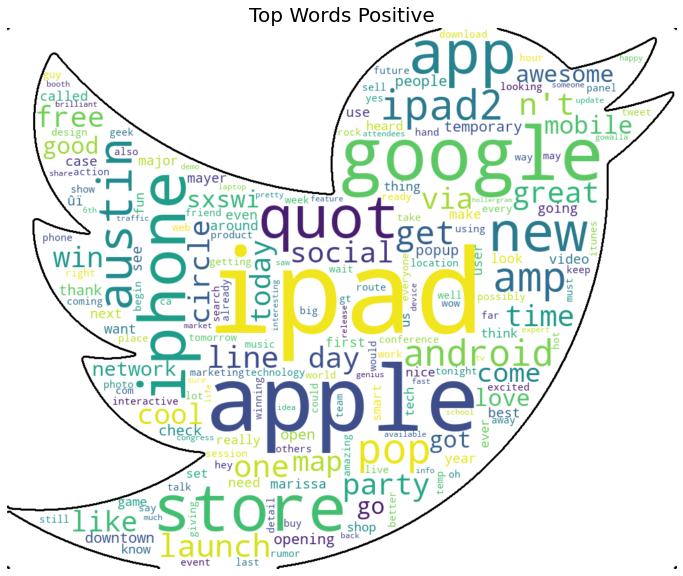

In [342]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False, mask=twitter_mask, 
                      background_color='white', width=1800,
                      height=1400, contour_color='black', contour_width=2)
wordcloud.generate(','.join(positive_stopped))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words Positive', size=20)
plt.axis("off")
plt.show()

### Visual: Negative Tweets

In [343]:
# creating a corpus for negative tweets only 
negative = df[df.type_of_emotion == "Negative emotion"]
negative_corpus = negative.tweet.to_list()
negative_corpus = ",".join(negative_corpus)

In [344]:
# word tokenize and lowercase all words 
negative_tokens = word_tokenize(negative_corpus)
negative_stopped = [token.lower() for token in negative_tokens if token.lower() not in stopwords_list]

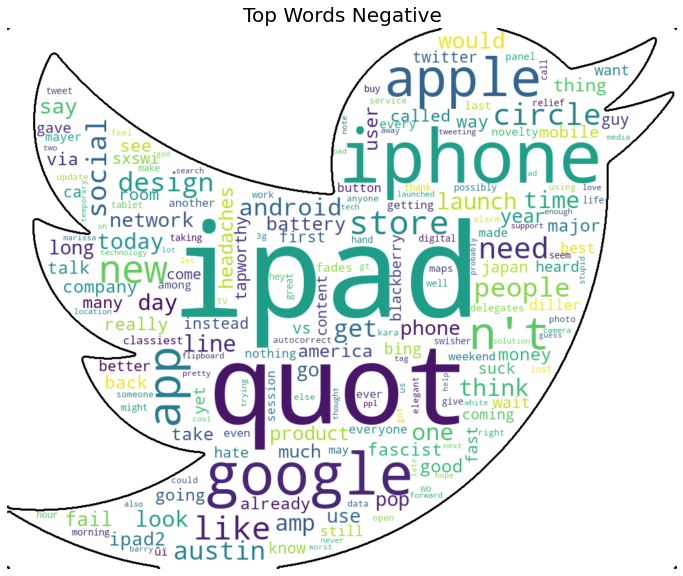

In [345]:
# generating a wordcloud with a twitter mask for negative words only 
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False, mask=twitter_mask, 
                      background_color='white', width=1800,
                      height=1400, contour_color='black', contour_width=2)
wordcloud.generate(','.join(negative_stopped))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words Negative', size=20)
plt.axis("off")
plt.show()

# Model 

## Train_test_split

In [346]:
# declaring X and y varibles 
X = df.tweet
y = df.type_of_emotion
y.value_counts(1)

No emotion          0.602954
Positive emotion    0.333259
Negative emotion    0.063787
Name: type_of_emotion, dtype: float64

In [347]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [348]:
# observing y_train value counts 
y_train.value_counts(1)

No emotion          0.601611
Positive emotion    0.337064
Negative emotion    0.061325
Name: type_of_emotion, dtype: float64

## Tfidf Vectorizer

### w/ word_tokenizer 

In [349]:
# instantiate Tfidf Vectorizer with word_tokenize 
word_tfidf = TfidfVectorizer(tokenizer = word_tokenize, stop_words=stopwords_list)

In [350]:
# word_tfidf fit_transform X_train, transfrom X_test
X_train_word_tfidf = word_tfidf.fit_transform(X_train)
X_test_word_tfidf = word_tfidf.transform(X_test)

### w/ tweet_tokenizer 

In [351]:
#  instantiate Tfidf Vectorizer with tweet tokenizer 
tweet_tfidf = TfidfVectorizer(tokenizer=tokenizer.tokenize , stop_words=stopwords_list)

In [352]:
# tweet_tfidf fit_transform X_train, transfrom X_test
X_train_tweet_tfidf = tweet_tfidf.fit_transform(X_train)
X_test_tweet_tfidf = tweet_tfidf.transform(X_test)

## Count Vectorizer 

### w/ word_tokenizer 

In [353]:
# instantiate CountVectorizer with word_tokenizer 
word_count = CountVectorizer(tokenizer = word_tokenize, stop_words=stopwords_list)

In [354]:
# word_count fit_transform X_train, transfrom X_test
X_train_word_count = word_count.fit_transform(X_train)
X_test_word_count = word_count.transform(X_test)

### w/ tweet_tokenizer

In [355]:
# instantiate CountVectorizer with tweet tokenizer 
tweet_count = CountVectorizer(tokenizer=tokenizer.tokenize , stop_words=stopwords_list)

In [356]:
# tweet_count fit_transform X_train, transfrom X_test
X_train_tweet_count = tweet_tfidf.fit_transform(X_train)
X_test_tweet_count = tweet_tfidf.transform(X_test)

## Support Vector Machines 

In [357]:
# instantiate SVC()
svc = SVC(class_weight='balanced')

### Tfidf Vectorizer w/ word_tokenizer 

In [358]:
# fit SVC 
svc.fit(X_train_word_tfidf, y_train)

# get predicitions 
y_pred = svc.predict(X_test_word_tfidf)

------------------------------------------------------------
SVC Tfidf Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.93       411
      No emotion       0.96      0.90      0.93      4032
Positive emotion       0.86      0.93      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



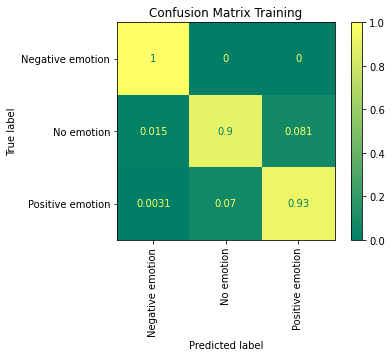

------------------------------------------------------------
SVC Tfidf Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.55      0.23      0.33       159
      No emotion       0.74      0.76      0.75      1356
Positive emotion       0.56      0.61      0.59       719

        accuracy                           0.67      2234
       macro avg       0.62      0.53      0.56      2234
    weighted avg       0.67      0.67      0.67      2234



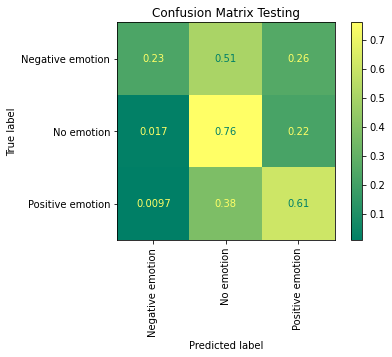

In [359]:
# classifcation report from evaluate_classification function 
evaluate_classification(svc, X_train_word_tfidf, X_test_word_tfidf, y_train, y_test, 
                       label = 'SVC Tfidf Word Tokenizer')

 ### Tfidf Vectorizer w/ tweet_tokenizer

In [360]:
# fit SVC 
svc.fit(X_train_tweet_tfidf, y_train)

# get predicitions 
y_pred = svc.predict(X_test_tweet_tfidf)

------------------------------------------------------------
SVC Tfidf Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.92       411
      No emotion       0.96      0.91      0.93      4032
Positive emotion       0.87      0.92      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



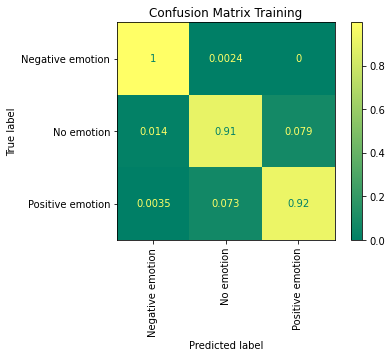

------------------------------------------------------------
SVC Tfidf Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.52      0.21      0.30       159
      No emotion       0.74      0.77      0.76      1356
Positive emotion       0.57      0.61      0.59       719

        accuracy                           0.68      2234
       macro avg       0.61      0.53      0.55      2234
    weighted avg       0.67      0.68      0.67      2234



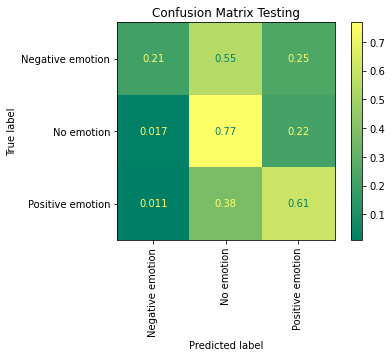

In [361]:
# classifcation report from evaluate_classification function
evaluate_classification(svc, X_train_tweet_tfidf, X_test_tweet_tfidf, y_train, y_test,
                       label = 'SVC Tfidf Tweet Tokenizer')

### Count Vectorizer w/ word_tokenizer 

In [362]:
# fit SVC 
svc.fit(X_train_word_count, y_train)

# get predicitions 
y_pred = svc.predict(X_test_word_count)

------------------------------------------------------------
SVC Count Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.84      1.00      0.91       411
      No emotion       0.94      0.86      0.90      4032
Positive emotion       0.81      0.89      0.85      2259

        accuracy                           0.88      6702
       macro avg       0.86      0.92      0.89      6702
    weighted avg       0.89      0.88      0.88      6702



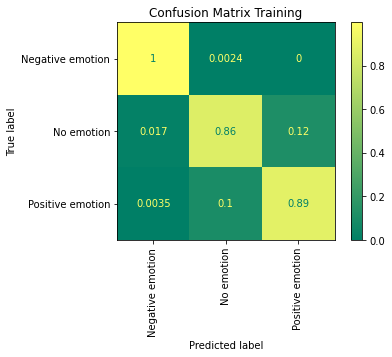

------------------------------------------------------------
SVC Count Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.55      0.25      0.34       159
      No emotion       0.75      0.74      0.75      1356
Positive emotion       0.55      0.64      0.59       719

        accuracy                           0.67      2234
       macro avg       0.62      0.54      0.56      2234
    weighted avg       0.67      0.67      0.67      2234



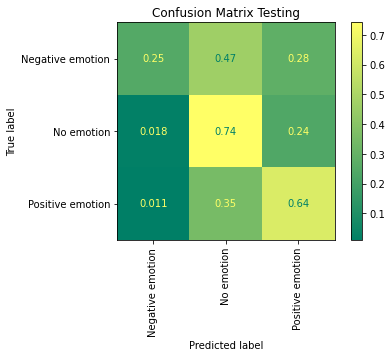

In [363]:
# classifcation report from evaluate_classification function
evaluate_classification(svc, X_train_word_count, X_test_word_count, y_train, y_test,
                       label = 'SVC Count Word Tokenizer')

### Count Vectorizer w/ tweet_tokenizer 

In [364]:
# fit SVC 
svc.fit(X_train_tweet_count, y_train)

# get predicitions 
y_pred = svc.predict(X_test_tweet_count)

------------------------------------------------------------
SVC Count Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.92       411
      No emotion       0.96      0.91      0.93      4032
Positive emotion       0.87      0.92      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



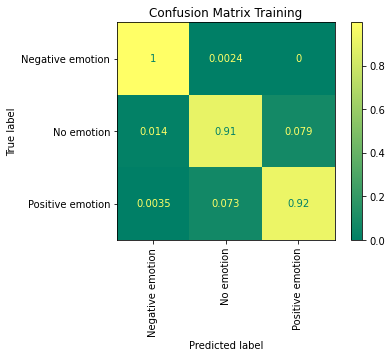

------------------------------------------------------------
SVC Count Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.52      0.21      0.30       159
      No emotion       0.74      0.77      0.76      1356
Positive emotion       0.57      0.61      0.59       719

        accuracy                           0.68      2234
       macro avg       0.61      0.53      0.55      2234
    weighted avg       0.67      0.68      0.67      2234



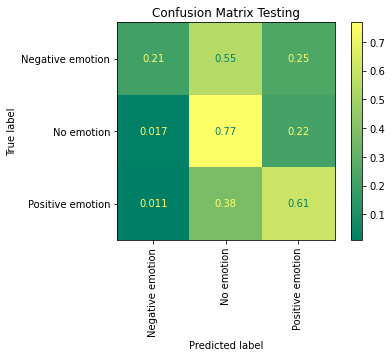

In [365]:
# classifcation report from evaluate_classification function
evaluate_classification(svc, X_train_tweet_count, X_test_tweet_count, y_train, y_test,
                       label = 'SVC Count Tweet Tokenizer')

## Random Forest Classifier 

In [366]:
# instantiate Random Forest Classifier 
rf = RandomForestClassifier(class_weight='balanced')

### Tfidf Vectorizer w/ word_tokenizer

In [367]:
# fit rf 
rf.fit(X_train_word_tfidf, y_train)

# get predicitions 
y_pred = rf.predict(X_test_word_tfidf)

------------------------------------------------------------
RF Tfidf Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.93      1.00      0.96       411
      No emotion       0.98      0.96      0.97      4032
Positive emotion       0.93      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



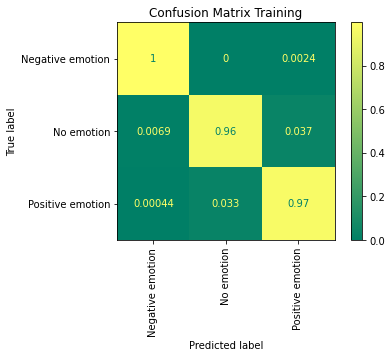

------------------------------------------------------------
RF Tfidf Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.62      0.16      0.25       159
      No emotion       0.69      0.85      0.76      1356
Positive emotion       0.59      0.45      0.51       719

        accuracy                           0.67      2234
       macro avg       0.64      0.48      0.51      2234
    weighted avg       0.66      0.67      0.65      2234



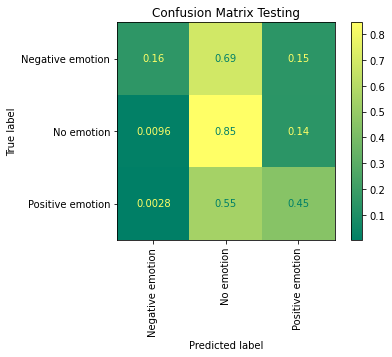

In [368]:
# classifcation report from evaluate_classification function
evaluate_classification(rf, X_train_word_tfidf, X_test_word_tfidf, y_train, y_test,
                       label = 'RF Tfidf Word Tokenizer')

### Tfidf Vectorizer w/ tweet_tokenizer

In [369]:
# fit rf
rf.fit(X_train_tweet_tfidf, y_train)

# get predicitions 
y_pred = rf.predict(X_test_tweet_tfidf)

------------------------------------------------------------
RF Tfidf Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.93      1.00      0.96       411
      No emotion       0.98      0.95      0.97      4032
Positive emotion       0.93      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



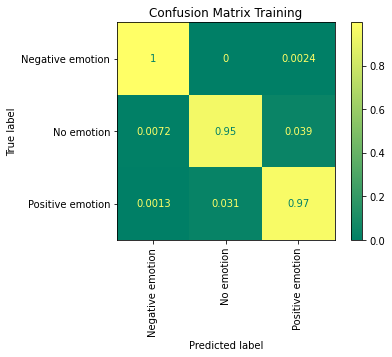

------------------------------------------------------------
RF Tfidf Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.63      0.17      0.27       159
      No emotion       0.71      0.84      0.77      1356
Positive emotion       0.62      0.49      0.55       719

        accuracy                           0.68      2234
       macro avg       0.65      0.50      0.53      2234
    weighted avg       0.67      0.68      0.66      2234



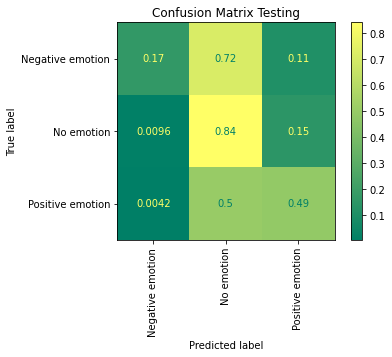

In [370]:
# classifcation report from evaluate_classification function
evaluate_classification(rf, X_train_tweet_tfidf, X_test_tweet_tfidf, y_train, y_test,
                       label = 'RF Tfidf Tweet Tokenizer')

### Count Vectorizer w/ word_tokenizer

In [371]:
# fit rf
rf.fit(X_train_word_count, y_train)

# get predicitions 
y_pred = rf.predict(X_test_word_count)

------------------------------------------------------------
RF Count Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.93      1.00      0.96       411
      No emotion       0.98      0.96      0.97      4032
Positive emotion       0.94      0.96      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



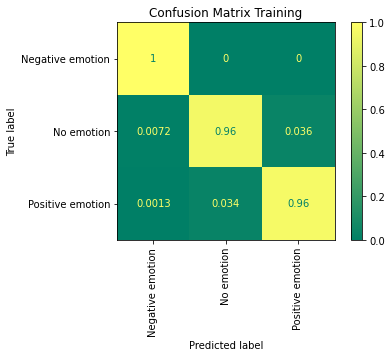

------------------------------------------------------------
RF Count Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.64      0.19      0.29       159
      No emotion       0.69      0.86      0.77      1356
Positive emotion       0.62      0.43      0.51       719

        accuracy                           0.68      2234
       macro avg       0.65      0.49      0.52      2234
    weighted avg       0.67      0.68      0.65      2234



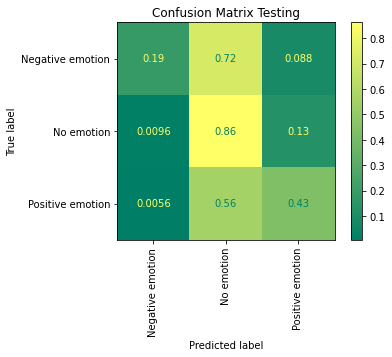

In [372]:
# classifcation report from evaluate_classification function
evaluate_classification(rf, X_train_word_count, X_test_word_count, y_train, y_test,
                       label = 'RF Count Word Tokenizer')

### Count Vectorizer w/ tweet_tokenizer

In [373]:
# fit rf
rf.fit(X_train_tweet_count, y_train)

# get predicitions 
y_pred = rf.predict(X_test_tweet_count)

------------------------------------------------------------
RF Count Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.92      1.00      0.96       411
      No emotion       0.98      0.95      0.97      4032
Positive emotion       0.93      0.96      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



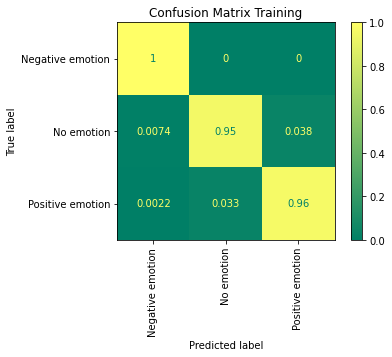

------------------------------------------------------------
RF Count Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.61      0.17      0.27       159
      No emotion       0.70      0.85      0.77      1356
Positive emotion       0.62      0.47      0.54       719

        accuracy                           0.68      2234
       macro avg       0.64      0.50      0.52      2234
    weighted avg       0.67      0.68      0.66      2234



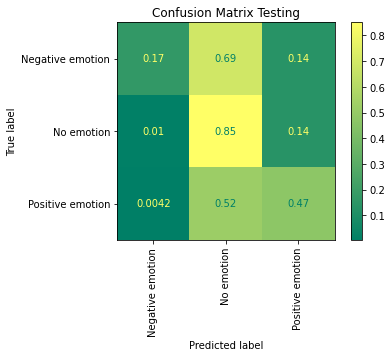

In [374]:
# classifcation report from evaluate_classification function
evaluate_classification(rf, X_train_tweet_count, X_test_tweet_count, y_train, y_test,
                       label = 'RF Count Tweet Tokenizer')

## MultinomialNB

In [375]:
# instantiate MultinomialNB
multi = MultinomialNB()

### Tfidf Vectorizer w/ word_tokenizer

In [376]:
# fit rf
multi.fit(X_train_word_tfidf, y_train)

# get predicitions 
y_pred = multi.predict(X_test_word_tfidf)

------------------------------------------------------------
Multinomial Tfidf Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.03      0.06       411
      No emotion       0.73      0.98      0.84      4032
Positive emotion       0.91      0.51      0.65      2259

        accuracy                           0.77      6702
       macro avg       0.88      0.51      0.52      6702
    weighted avg       0.81      0.77      0.73      6702



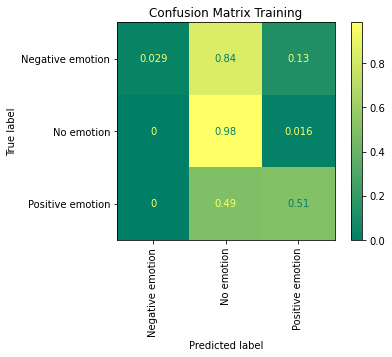

------------------------------------------------------------
Multinomial Tfidf Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.50      0.01      0.01       159
      No emotion       0.65      0.94      0.77      1356
Positive emotion       0.68      0.26      0.38       719

        accuracy                           0.66      2234
       macro avg       0.61      0.40      0.39      2234
    weighted avg       0.65      0.66      0.59      2234



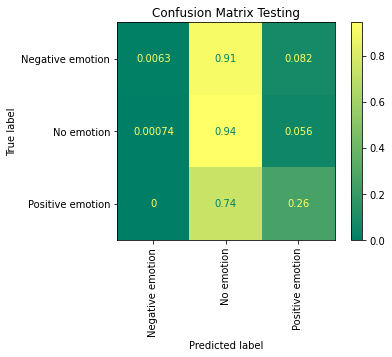

In [377]:
# classifcation report from evaluate_classification function
evaluate_classification(multi, X_train_word_tfidf, X_test_word_tfidf, y_train, y_test,
                       label = 'Multinomial Tfidf Word Tokenizer')

### Tfidf Vectorizer w/ tweet_tokenizer

In [378]:
# fit rf
multi.fit(X_train_tweet_tfidf, y_train)

# get predicitions 
y_pred = multi.predict(X_test_tweet_tfidf)

------------------------------------------------------------
Multinomial Tfidf Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.05      0.10       411
      No emotion       0.74      0.99      0.84      4032
Positive emotion       0.91      0.52      0.66      2259

        accuracy                           0.77      6702
       macro avg       0.88      0.52      0.53      6702
    weighted avg       0.81      0.77      0.73      6702



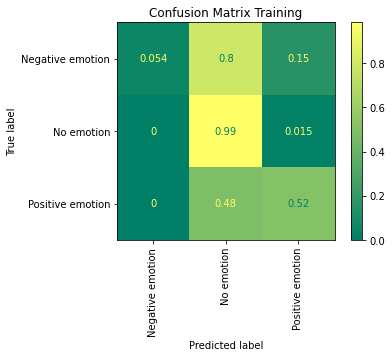

------------------------------------------------------------
Multinomial Tfidf Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.01      0.02       159
      No emotion       0.66      0.94      0.78      1356
Positive emotion       0.69      0.28      0.40       719

        accuracy                           0.67      2234
       macro avg       0.78      0.41      0.40      2234
    weighted avg       0.69      0.67      0.60      2234



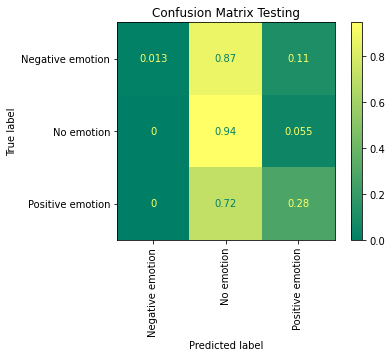

In [379]:
# classifcation report from evaluate_classification function
evaluate_classification(multi, X_train_tweet_tfidf, X_test_tweet_tfidf, y_train, y_test,
                       label = 'Multinomial Tfidf Tweet Tokenizer')

### Count Vectorizer w/ word_tokenizer

In [380]:
# fit rf
multi.fit(X_train_word_count, y_train)

# get predicitions 
y_pred = multi.predict(X_test_word_count)

------------------------------------------------------------
Multinomial Count Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.87      0.47      0.61       411
      No emotion       0.86      0.90      0.88      4032
Positive emotion       0.79      0.80      0.79      2259

        accuracy                           0.84      6702
       macro avg       0.84      0.72      0.76      6702
    weighted avg       0.84      0.84      0.84      6702



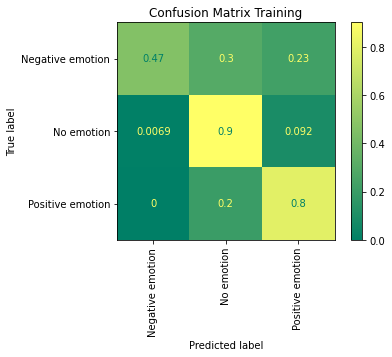

------------------------------------------------------------
Multinomial Count Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.46      0.10      0.16       159
      No emotion       0.71      0.78      0.75      1356
Positive emotion       0.54      0.54      0.54       719

        accuracy                           0.65      2234
       macro avg       0.57      0.47      0.48      2234
    weighted avg       0.64      0.65      0.64      2234



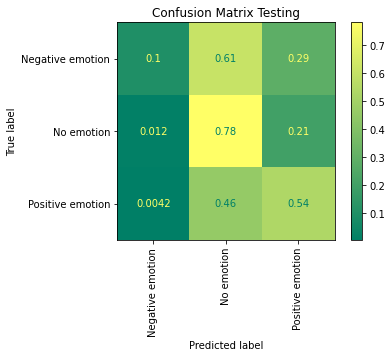

In [381]:
# classifcation report from evaluate_classification function
evaluate_classification(multi, X_train_word_count, X_test_word_count, y_train, y_test,
                       label = 'Multinomial Count Word Tokenizer')

### Count Vectorizer w/ tweet_tokenizer

In [382]:
# fit rf
multi.fit(X_train_tweet_count, y_train)

# get predicitions 
y_pred = multi.predict(X_test_tweet_count)

------------------------------------------------------------
Multinomial Count Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.05      0.10       411
      No emotion       0.74      0.99      0.84      4032
Positive emotion       0.91      0.52      0.66      2259

        accuracy                           0.77      6702
       macro avg       0.88      0.52      0.53      6702
    weighted avg       0.81      0.77      0.73      6702



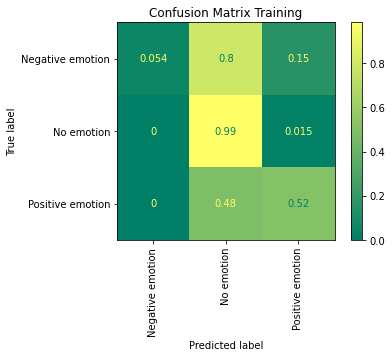

------------------------------------------------------------
Multinomial Count Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.01      0.02       159
      No emotion       0.66      0.94      0.78      1356
Positive emotion       0.69      0.28      0.40       719

        accuracy                           0.67      2234
       macro avg       0.78      0.41      0.40      2234
    weighted avg       0.69      0.67      0.60      2234



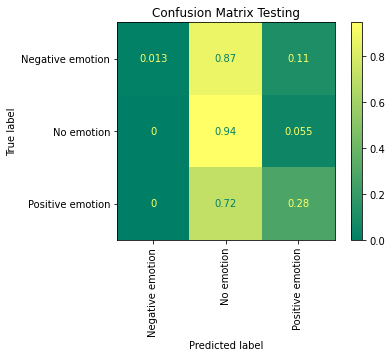

In [383]:
# classifcation report from evaluate_classification function
evaluate_classification(multi, X_train_tweet_count, X_test_tweet_count, y_train, y_test,
                       label = 'Multinomial Count Tweet Tokenizer')

## Support Vectors Machine Gridsearch

**TFIDF w/ Word_Tokenizer Gridsearch**

In [384]:
# create params_grid for Suppot Vectors Machine  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_svc.fit(X_train_word_tfidf, y_train)

# observe combination of best params 
grid_svc.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

------------------------------------------------------------
SVC Tfidf Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.93       411
      No emotion       0.96      0.90      0.93      4032
Positive emotion       0.86      0.93      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



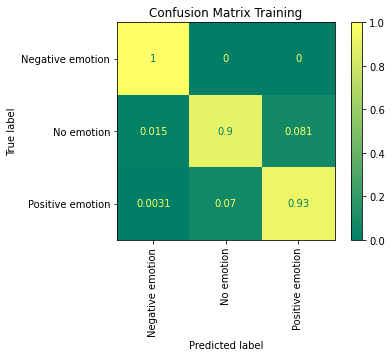

------------------------------------------------------------
SVC Tfidf Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.55      0.23      0.33       159
      No emotion       0.74      0.76      0.75      1356
Positive emotion       0.56      0.61      0.59       719

        accuracy                           0.67      2234
       macro avg       0.62      0.53      0.56      2234
    weighted avg       0.67      0.67      0.67      2234



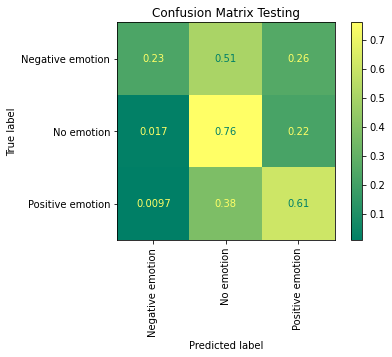

In [385]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_svc.best_estimator_, X_train_word_tfidf, X_test_word_tfidf, y_train, y_test,
                       label = 'SVC Tfidf Word Tokenizer')

**TFIDF w/ Tweet_Tokenizer Gridsearch**

In [386]:
# create params_grid for Suppot Vectors Machine  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_svc.fit(X_train_tweet_tfidf, y_train)

# observe combination of best params 
grid_svc.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

------------------------------------------------------------
SVC Tfidf Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.92       411
      No emotion       0.96      0.91      0.93      4032
Positive emotion       0.87      0.92      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



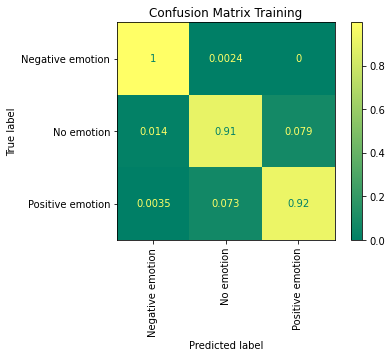

------------------------------------------------------------
SVC Tfidf Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.52      0.21      0.30       159
      No emotion       0.74      0.77      0.76      1356
Positive emotion       0.57      0.61      0.59       719

        accuracy                           0.68      2234
       macro avg       0.61      0.53      0.55      2234
    weighted avg       0.67      0.68      0.67      2234



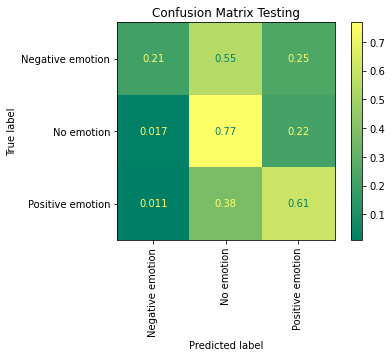

In [387]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_svc.best_estimator_, X_train_tweet_tfidf, X_test_tweet_tfidf, y_train, y_test,
                       label = 'SVC Tfidf Tweet Tokenizer')

**Count w/ Word_Tokenizer Gridsearch**

In [388]:
# create params_grid for Suppot Vectors Machine  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_svc.fit(X_train_word_count, y_train)

# observe combination of best params 
grid_svc.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

------------------------------------------------------------
SVC Count Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.84      1.00      0.91       411
      No emotion       0.94      0.86      0.90      4032
Positive emotion       0.81      0.89      0.85      2259

        accuracy                           0.88      6702
       macro avg       0.86      0.92      0.89      6702
    weighted avg       0.89      0.88      0.88      6702



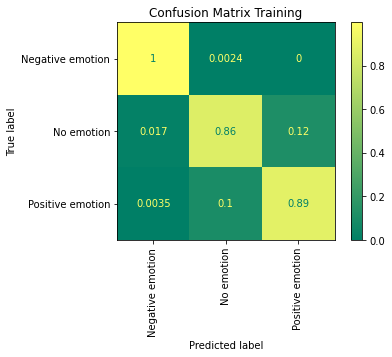

------------------------------------------------------------
SVC Count Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.55      0.25      0.34       159
      No emotion       0.75      0.74      0.75      1356
Positive emotion       0.55      0.64      0.59       719

        accuracy                           0.67      2234
       macro avg       0.62      0.54      0.56      2234
    weighted avg       0.67      0.67      0.67      2234



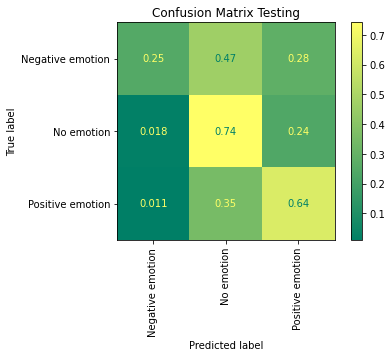

In [389]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_svc.best_estimator_, X_train_word_count, X_test_word_count, y_train, y_test,
                       label = 'SVC Count Word Tokenizer')

**Count w/ Tweet_Tokenizer Gridsearch**

In [391]:
# create params_grid for Suppot Vectors Machine  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_svc.fit(X_train_tweet_count, y_train)

# observe combination of best params 
grid_svc.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

------------------------------------------------------------
SVC Count Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      1.00      0.92       411
      No emotion       0.96      0.91      0.93      4032
Positive emotion       0.87      0.92      0.89      2259

        accuracy                           0.92      6702
       macro avg       0.90      0.94      0.92      6702
    weighted avg       0.92      0.92      0.92      6702



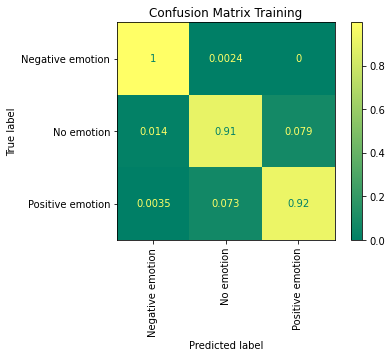

------------------------------------------------------------
SVC Count Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.52      0.21      0.30       159
      No emotion       0.74      0.77      0.76      1356
Positive emotion       0.57      0.61      0.59       719

        accuracy                           0.68      2234
       macro avg       0.61      0.53      0.55      2234
    weighted avg       0.67      0.68      0.67      2234



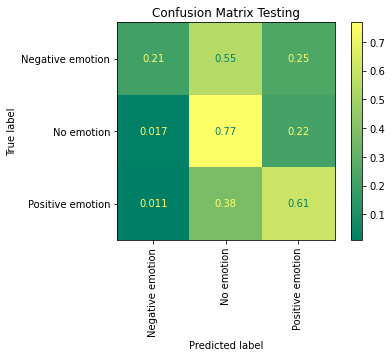

In [392]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_svc.best_estimator_, X_train_tweet_count, X_test_tweet_count, y_train, y_test,
                       label = 'SVC Count Tweet Tokenizer')

## Random Forest Gridsearch 

**TFIDF w/ Word_Tokenizer Gridsearch**

In [393]:
# create params_grid for Random Forest  
params_grid = {'criterion' : ["gini", "entropy"],
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}
# create grid search 
grid_rf = GridSearchCV(rf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_rf.fit(X_train_word_tfidf, y_train)

# observe combination of best params 
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
RF Tfidf Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.93      1.00      0.96       411
      No emotion       0.98      0.95      0.97      4032
Positive emotion       0.93      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



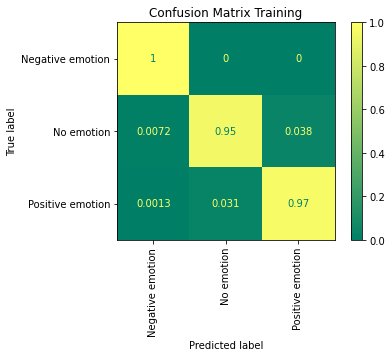

------------------------------------------------------------
RF Tfidf Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.64      0.17      0.27       159
      No emotion       0.70      0.84      0.76      1356
Positive emotion       0.60      0.46      0.52       719

        accuracy                           0.67      2234
       macro avg       0.65      0.49      0.52      2234
    weighted avg       0.66      0.67      0.65      2234



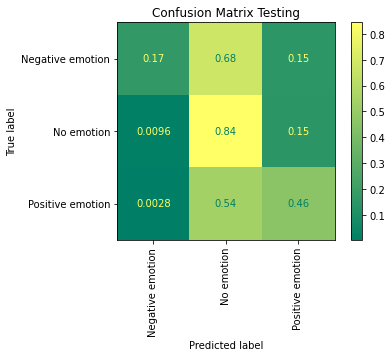

In [395]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_rf.best_estimator_, X_train_word_tfidf, X_test_word_tfidf, y_train, y_test,
                       label = 'RF Tfidf Word Tokenizer')

**TFIDF w/ Tweet_Tokenizer Gridsearch**

In [396]:
# create params_grid for Random Forest 
params_grid = {'criterion' : ["gini", "entropy"],
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid_rf = GridSearchCV(rf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_rf.fit(X_train_tweet_tfidf, y_train)

# observe combination of best params 
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
RF Tfidf Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.92      1.00      0.96       411
      No emotion       0.98      0.95      0.97      4032
Positive emotion       0.93      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



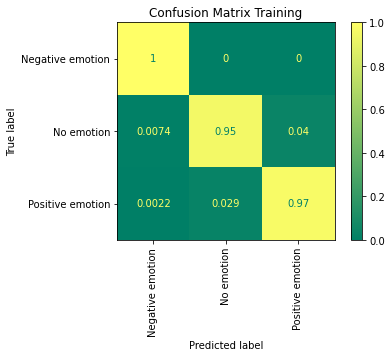

------------------------------------------------------------
RF Tfidf Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.63      0.17      0.27       159
      No emotion       0.71      0.85      0.77      1356
Positive emotion       0.61      0.48      0.54       719

        accuracy                           0.68      2234
       macro avg       0.65      0.50      0.52      2234
    weighted avg       0.67      0.68      0.66      2234



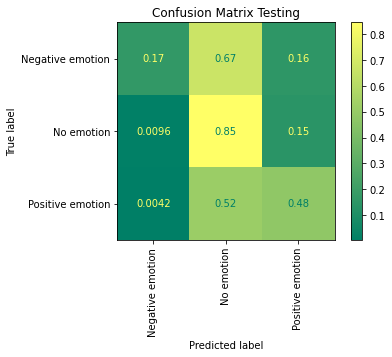

In [397]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_rf.best_estimator_, X_train_tweet_tfidf, X_test_tweet_tfidf, y_train, y_test,
                       label = 'RF Tfidf Tweet Tokenizer')

**Count w/ Word_Tokenizer Gridsearch**

In [398]:
# create params_grid for Random Forest  
params_grid = {'criterion' : ["gini", "entropy"],
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid_rf = GridSearchCV(rf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_rf.fit(X_train_word_count, y_train)

# observe combination of best params 
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
RF Count Word Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.93      1.00      0.96       411
      No emotion       0.98      0.96      0.97      4032
Positive emotion       0.94      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



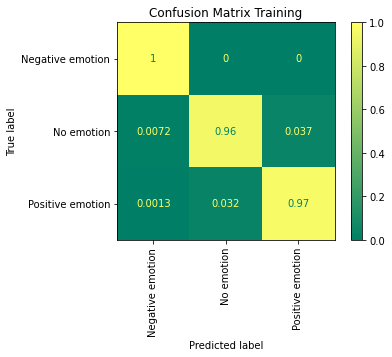

------------------------------------------------------------
RF Count Word Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.64      0.19      0.29       159
      No emotion       0.69      0.86      0.77      1356
Positive emotion       0.63      0.43      0.51       719

        accuracy                           0.68      2234
       macro avg       0.65      0.49      0.52      2234
    weighted avg       0.67      0.68      0.65      2234



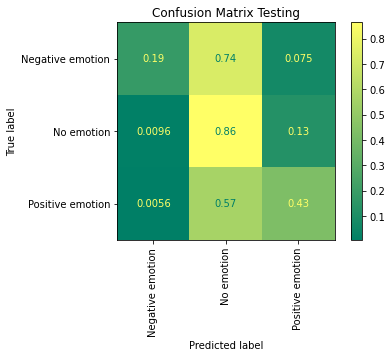

In [399]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_rf.best_estimator_, X_train_word_count, X_test_word_count, y_train, y_test,
                       label = 'RF Count Word Tokenizer')

**Count w/ Tweet_Tokenizer Gridsearch** 

In [400]:
# create params_grid for Random Forest  
params_grid = {'criterion' : ["gini", "entropy"],
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid_rf = GridSearchCV(rf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid_rf.fit(X_train_tweet_count, y_train)

# observe combination of best params 
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
RF Count Tweet Tokenizer CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.92      1.00      0.96       411
      No emotion       0.98      0.95      0.97      4032
Positive emotion       0.93      0.97      0.95      2259

        accuracy                           0.96      6702
       macro avg       0.95      0.97      0.96      6702
    weighted avg       0.96      0.96      0.96      6702



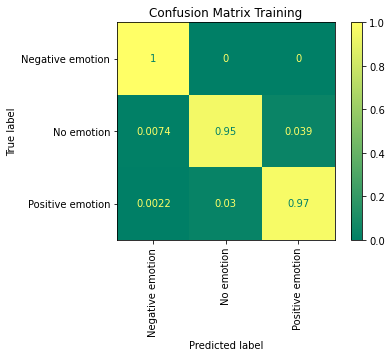

------------------------------------------------------------
RF Count Tweet Tokenizer CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                  precision    recall  f1-score   support

Negative emotion       0.62      0.16      0.26       159
      No emotion       0.70      0.84      0.77      1356
Positive emotion       0.61      0.47      0.53       719

        accuracy                           0.68      2234
       macro avg       0.64      0.49      0.52      2234
    weighted avg       0.67      0.68      0.65      2234



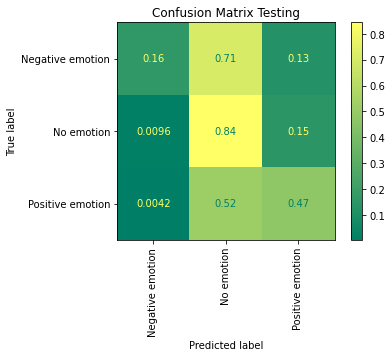

In [401]:
# classifcation report from evaluate_classification function
evaluate_classification(grid_rf.best_estimator_, X_train_tweet_count, X_test_tweet_count, y_train, y_test,
                       label = 'RF Count Tweet Tokenizer')

# iNtrepretation 

According to the vanilla models, Support Vectors Machine and Random Forest yielded similar results while MultinomialNB was slightly lower in training and test scores. SVM  had an average accuracy score of .92 for the training data and an average accuracy score of .68 for the test data. After performing a gridsearch for SVM, we have concluded any method of vectorization and tokenization will do. For our interpetation and visuals, we will use the Support Vectors Machine classifier with the following parameters:
>* Tf-idf vectorizer 
* Word_tokenizer
* kernel = linear
* gamma = scale 

Random Forest Classifier was not chosen due to the accuracy score resulting in .99 or 100 for the training data and an average accuracy score of .675 for the test data. The high to near perfect score for the training data shows signs of over-fitting which is also apparent in the relatively low accuracy score for the test data. 

MultinomialNB was not a chosen classifier due to the low accuracy scores of .83
and below for the training data and .67 and below for the test data. 


## LIME Visuals 

In [402]:
# vectorizing, fit_transfrorm data, and creating a pipe line
vectorizer = TfidfVectorizer(tokenizer = word_tokenize, stop_words=stopwords_list)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
svc = SVC(probability=True, class_weight='balanced', kernel='linear', gamma='scale')
svc.fit(train_vectors, y_train)
c = make_pipeline(vectorizer, svc)
c

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function word_tokenize at 0x7f8525a230d0>)),
                ('svc',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [403]:
# instantiate LIME and build 
class_names = ['positive', 'negative', 'neutral']
explainer = LimeTextExplainer(class_names=class_names)
idx = 3
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, labels = [0,1,2])

#fig = exp.as_pyplot_figure()
exp.show_in_notebook()

In [404]:
# LIME visual 
idx = 50
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, labels = [0,1,2])

#fig = exp.as_pyplot_figure()
exp.show_in_notebook()

In [405]:
# LIME visual 
idx = 25
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, labels = [0,1,2])

#fig = exp.as_pyplot_figure()
exp.show_in_notebook()

In [463]:
# LIME visual 
idx = 200
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, labels = [0,1,2])

#fig = exp.as_pyplot_figure()
exp.show_in_notebook()

# Conclusion

The Support Vector Machines model returned an accuracy rate of 68%. Any method of vectorization (count/tfidf) combined with any method of tokenizer (word_tokenizer/tweet tokenizer) would yield the same results. According to the visuals produced, positive tweets, negative tweets and neutral tweets all have similar terms with high frequency. After reviewing the data, we have the following recommendations; 
* Both Google and Apple should have a strong presence at the yearly South by Southwest music and media festivals 
* Promotional offers to users who send out positive tweets
* Monitor and respond negative tweets live 